## **Imports**

In [ ]:
# Basic import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


# Keras import
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,ReduceLROnPlateau

#sklearn import
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
!pip install kaggle


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"kagglecomabubakar","key":"1ec7345524fb7ca73567796c2be50455"}'}

In [ ]:

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset")

Dataset URL: https://www.kaggle.com/datasets/jonathanoheix/face-expression-recognition-dataset


100%|██████████| 121M/121M [00:00<00:00, 613MB/s] 


In [ ]:
!ls


face-expression-recognition-dataset  kaggle.json  sample_data


In [ ]:
!ls face-expression-recognition-dataset/

images


In [ ]:
!ls face-expression-recognition-dataset/images

images	train  validation


In [ ]:
!ls face-expression-recognition-dataset/images/train

angry  disgust	fear  happy  neutral  sad  surprise


In [ ]:
data_path = os.listdir('/content/face-expression-recognition-dataset/images/train')
data_path


['disgust', 'surprise', 'fear', 'angry', 'happy', 'neutral', 'sad']

In [ ]:
#count the total number of image in each class

data_path = '/content/face-expression-recognition-dataset/images/train'


total_images = 0

for class_name in os.listdir(data_path):
    class_path = os.path.join(data_path, class_name)
    if os.path.isdir(class_path):  # make sure it’s a folder  // if class_path is not None
        count = len(os.listdir(class_path))
        total_images += count
        print(f"{class_name}: {count} images")

print(f"\nTotal images in dataset: {total_images}")


disgust: 436 images
surprise: 3205 images
fear: 4103 images
angry: 3993 images
happy: 7164 images
neutral: 4982 images
sad: 4938 images

Total images in dataset: 28821


In [ ]:
path_dir = '/content/face-expression-recognition-dataset/images'
train_dir = os.path.join(path_dir, 'train')
validation_dir = os.path.join(path_dir, 'validation')

In [ ]:
# other and direct way to count the all the image in subfloder of directory


import pathlib
data_dir = pathlib.Path(data_path)
data_dir

PosixPath('/content/face-expression-recognition-dataset/images/train')

In [ ]:
happy= list(data_dir.glob("happy/*"))


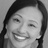

In [ ]:
import PIL
x= PIL.Image.open(str(happy[2]))
x

In [ ]:
train_gen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

validation_gen = ImageDataGenerator(rescale=1./255)



train_generator = train_gen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

validation_generator = validation_gen.flow_from_directory(
    validation_dir,
    target_size=(48, 48),
    batch_size=64,
    class_mode='categorical',
    color_mode='grayscale'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [ ]:
class_names = list(train_generator.class_indices.keys())

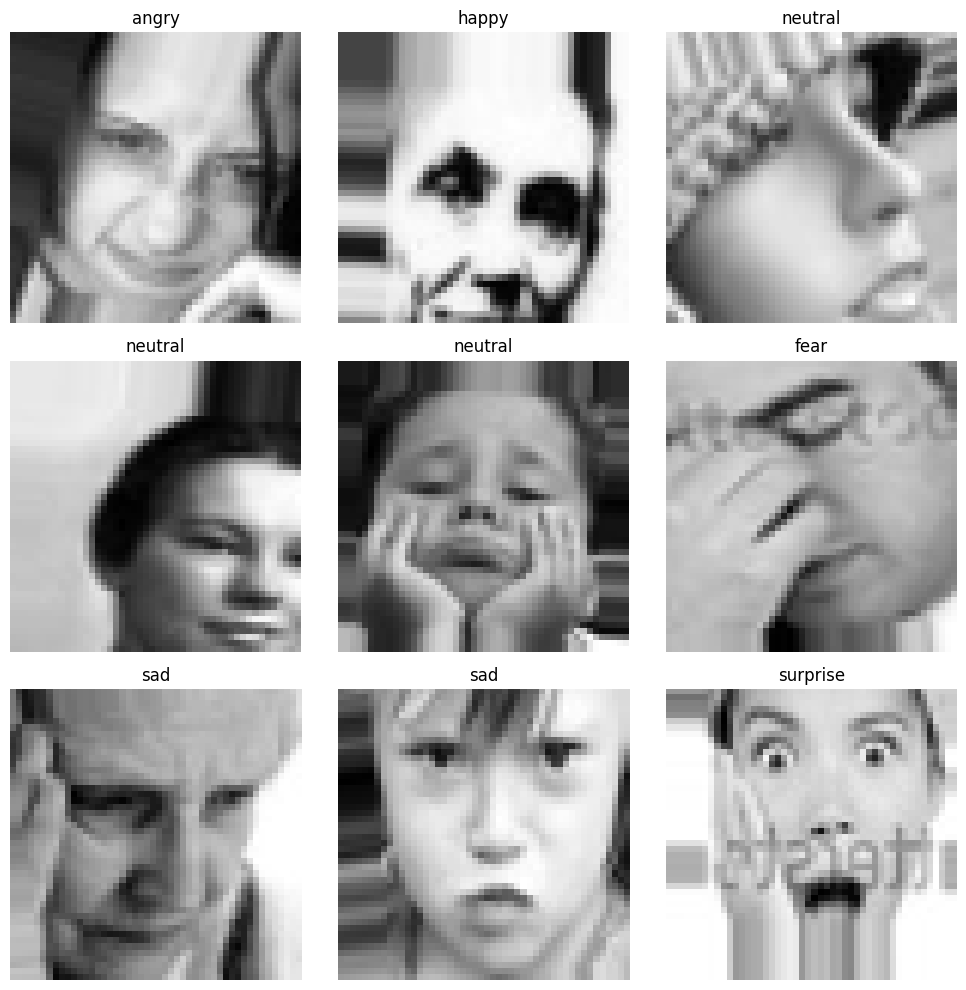

In [ ]:
class_names = list(train_generator.class_indices.keys())

images, labels = next(train_generator)
plt.figure(figsize=(10, 10))
for i in range(9):
    plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].reshape(48, 48), cmap='gray')
    plt.title(class_names[np.argmax(labels[i])])

    plt.axis('off')
plt.tight_layout()
plt.show()

## **CNN Model Architecture**

In [ ]:
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.25),

    Flatten(),
    Dense(512, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),

    Dense(7, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 46, 46, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 46, 46, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 21, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 8, 8, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 8, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 4, 4, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,474,759 (9.44 MB)

 Trainable params: 2,472,839 (9.43 MB)

 Non-trainable params: 1,920 (7.50 KB)

## ** Model Training**

In [ ]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Model Training
history = model.fit(
    train_generator,
    epochs=50,
    validation_data=validation_generator,
    callbacks=[early_stopping, lr_scheduler]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 51s 76ms/step - accuracy: 0.1962 - loss: 2.5119 - val_accuracy: 0.2597 - val_loss: 1.8472 - learning_rate: 0.0010
Epoch 2/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 25s 56ms/step - accuracy: 0.2496 - loss: 1.8799 - val_accuracy: 0.3462 - val_loss: 1.6661 - learning_rate: 0.0010
Epoch 3/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 27s 59ms/step - accuracy: 0.3239 - loss: 1.7089 - val_accuracy: 0.2781 - val_loss: 1.7335 - learning_rate: 0.0010
Epoch 4/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 32s 70ms/step - accuracy: 0.3693 - loss: 1.6136 - val_accuracy: 0.3929 - val_loss: 1.5543 - learning_rate: 0.0010
Epoch 5/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.3909 - loss: 1.5642 - val_accuracy: 0.3825 - val_loss: 1.5564 - learning_rate: 0.0010
Epoch 6/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 26s 57ms/step - accuracy: 0.4148 - loss: 1.5104 - val_accuracy: 0.3569 - val_loss: 1.6338 - learning_rate: 0.0010
Epoch 7/50
451/451 ━━━━━━━━━━━━━━━━━━━━ 26s 58ms/step - accuracy: 0.4205 - l

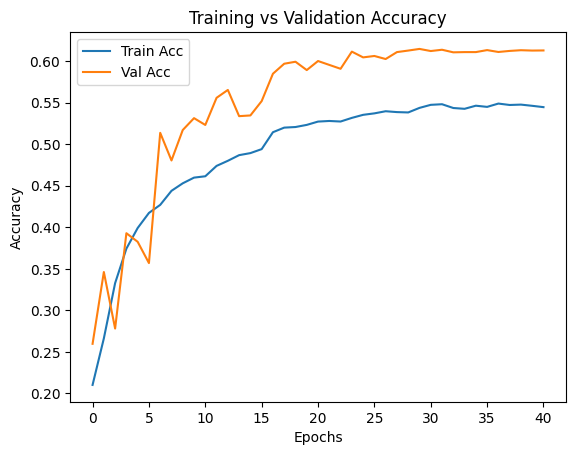

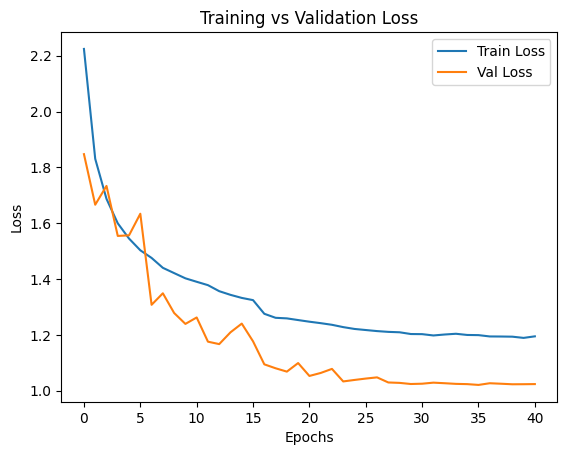

In [ ]:
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## **Evaluation - Classification Report & Confusion Matrix**

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
              precision    recall  f1-score   support

       angry       0.31      0.50      0.38        10
     disgust       0.00      0.00      0.00         4
        fear       0.50      0.15      0.24        13
       happy       0.73      0.79      0.76        14
     neutral       0.43      0.67      0.52         9
         sad       0.38      0.30      0.33        10
    surprise       0.50      0.75      0.60         4

    accuracy                           0.47        64
   macro avg       0.41      0.45      0.40        64
weighted avg       0.46      0.47      0.44        64



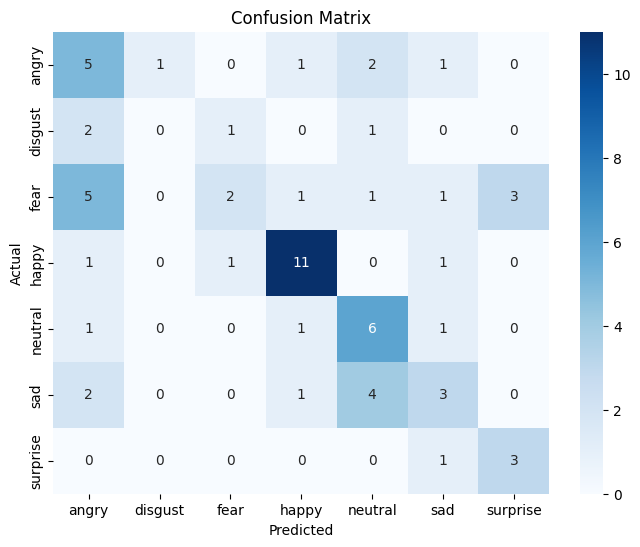

In [ ]:
# 6. Evaluation - Classification Report & Confusion Matrix
val_images, val_labels = next(validation_generator)
predictions = model.predict(val_images)
y_true = np.argmax(val_labels, axis=1)
y_pred = np.argmax(predictions, axis=1)

print(classification_report(y_true, y_pred, target_names=class_names))

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## ** Detection System**

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 744ms/step


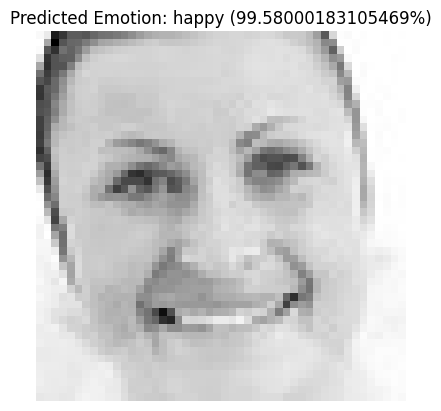

Emotion: happy, Confidence: 99.58000183105469%


In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
import numpy as np

def detect_emotion(image_path):
    img = image.load_img(image_path, target_size=(48, 48), color_mode='grayscale')
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    prediction = model.predict(img_array)
    predicted_index = np.argmax(prediction)
    predicted_class = class_names[predicted_index]
    confidence = round(prediction[0][predicted_index] * 100, 2)  # Confidence in %

    # Display the image with the predicted label and confidence
    plt.imshow(img, cmap='gray')
    plt.title(f'Predicted Emotion: {predicted_class} ({confidence}%)')
    plt.axis('off')
    plt.show()

    return predicted_class, confidence

# Example Detection
predicted_emotion, confidence = detect_emotion('/content/face-expression-recognition-dataset/images/train/happy/10035.jpg')
print(f"Emotion: {predicted_emotion}, Confidence: {confidence}%")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step


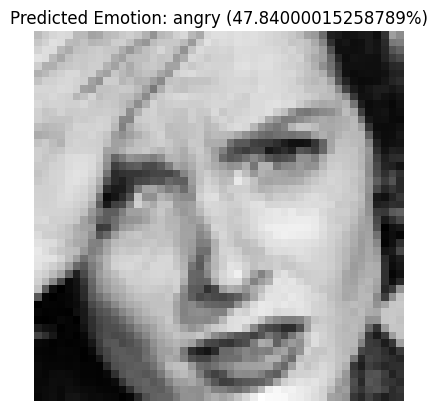

('angry', np.float32(47.84))


In [ ]:
# Example Detection
print(detect_emotion('/content/face-expression-recognition-dataset/images/train/fear/10025.jpg'))

In [ ]:
# Example Detection
print(detect_emotion('/kaggle/input/face-expression-recognition-dataset/images/train/angry/10207.jpg'))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/input/face-expression-recognition-dataset/images/train/angry/10207.jpg'

## **Model Save**

In [ ]:
model.save('facial_emotion_detection_model.h5')